# Projet Maths-Info

On cherche à tracer les lignes de niveau d'une fonction à deux variables.

In [2]:
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import bisect

Pour une fonction f continue, si c ∈ [f(0,0),f(0,1)] ou c ∈ [f(0,1),f(0,0)], alors le théorème des valeurs intermédiaires garantit l'existence d'un t ∈ [0,1] tel que f(0,t) = c
On choisit donc cette condition.

Pour le programme find_seed, nous procédons par dichotomie.

In [1]:
def dichotomie(f,a,b,epsilon):
    g,d=a,b
    while (d-g)>epsilon:
        c=(d+g)/2
        if f(a)*f(c)<0:
            d=c
        else:
            g=c
    return c


def find_seed(g, c=0.0, eps=2**(-26)):
    if (g(0,0)-c)*(g(0,1)-c)<0:  
        tmp=lambda x : g(0,x)-c  #On se ramène à une fonction d'une seule variable pour rechercher un zero de g sur un chemin du plan, ici le bord gauche
        return dichotomie(tmp,0,1,2**-26)
    else:
        return None

Le gradient étant toujours orthogonal aux lignes de niveaux, nous calculons le gradient puis un vecteur orthogonal à celui-ci (noté n, calculé en effectuant le produit vectoriel du gradient avec (0,0,1)), auquel on donne une norme delta. Ce calcul nous fournit uniquement la direction que l'on doit suivre mais pas le sens. Pour le déterminer, on teste si se décaler de delta selon n nous fais sortir de [0,1]x[0,1], si oui on multiplie notre vecteur n par -1. Une fois le sens de départ connu, on suit la ligne de niveau en se décalant de n normé à delta, en gardant le même signe.

À chaque itération, on se décale légèrement de la vraie ligne de niveau. Cependant, dans la fonction contour suivante, on utilise une grille. À chaque changement de case de cette grille, on se recale sur la véritable ligne de niveau à l'aide d'une dichotomie, il suffit donc de prendre une grille suffisamment fine pour résoudre ce problème.


In [3]:
def grad_f(x, y):
    g = autograd.grad
    return np.r_[g(f, 0)(x, y), g(f, 1)(x, y)]


def simple_contour(f, c=0.0, delta=0.01):
    X,Y=[],[]
    d0=find_seed(f,c)
    if d0!=None:
        x,y=0.0001,d0 #Une erreur interne à autograd survenait si on évaluait la fonction grad_f avec l'une des coordonées nulle
        gradient=grad_f(x,y)
        s = 1 #Variable qui indique le sens à choisir
        if gradient[1] < 0: #On teste si se décaler d'un vecteur orthogonal à "gradient" nous ferait sortir de [0,1]x[0,1]
            s = -1
        print(s)
        while 0<=x<1 and 0<=y<1:
            X.append(x)
            Y.append(y)
            gradient=grad_f(x,y)
            n=[gradient[1],-gradient[0]]
            norme=s*np.sqrt(n[0]**2+n[1]**2)
            if norme!=0:
                x+=delta/norme*n[0]
                y+=delta/norme*n[1]
            else:
                break
        
    return X,Y

On teste la fonction sur un exemple.

1


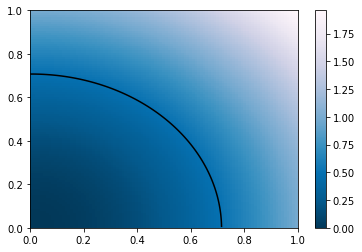

In [4]:
f=lambda x,y:x**2+y**2
X,Y=np.linspace(0,1,100),np.linspace(0,1,100)

X,Y=np.meshgrid(X,Y)

Z=f(X,Y)

plt.pcolormesh(X, Y, Z,cmap='PuBu_r')
plt.colorbar()

X_l,Y_l=simple_contour(f,0.5)
plt.plot(X_l,Y_l,color="black")

Pour la fonction contour, nous avons du adapter la fonction find_seed pour pouvoir trouver un point sur n'importe quel coté d'une case de la grille crée. Nous avons écrit une fonction case qui trouve tous les points de la ligne de niveau dans une case. 

In [6]:
def find_seed_4(g,c,x0,y0,x1,y1, eps=2**(-26)):
    eps=2**-26
    res=[]
    if (g(x0,y0)-c)*(g(x0,y1)-c)<0:  
        tmp=lambda x : g(x0,x)-c
        res.append((x0,dichotomie(tmp,y0,y1,eps)))
    if (g(x0,y1)-c)*(g(x1,y1)-c)<0:
        tmp=lambda x : g(x,y1)-c 
        res.append((dichotomie(tmp,x0,x1,eps),y1))
    if (g(x1,y1)-c)*(g(x1,y0)-c)<0:
        tmp=lambda x : g(x1,x)-c 
        res.append((x1,dichotomie(tmp,y0,y1,eps)))
    if (g(x1,y0)-c)*(g(x0,y0)-c)<0:
        tmp=lambda x : g(x,y0)-c 
        res.append((dichotomie(tmp,x0,x1,eps),y0))
    return res

def case(f,c,x0,y0,x1,y1,delta):
    X,Y=[],[]
    seed=find_seed_4(f,c,x0,y0,x1,y1)
    if seed!=[]:
        for x,y in seed:
            gradient=grad_f(x+0.00001,y+0.00001) #Une erreur interne à autograd survenait si on évaluait la fonction grad_f avec l'une des coordonées nulle
            n=[gradient[1],-gradient[0]]
            norme=np.sqrt(n[0]**2+n[1]**2)
            if norme!=0:
                x+=delta/norme*n[0]
                y+=delta/norme*n[1]            
            s = -1 #On utilise toujours la même méthode que dans simple_contour pour déterminer le sens
            if x0<=x<=x1 and y0<=y<=y1:
                s = 1
            while x0<=x<=x1 and y0<=y<=y1:
                X.append(x)
                Y.append(y)
                gradient=grad_f(x+0.00001,y+0.00001)
                n=[gradient[1],-gradient[0]]
                norme=s*np.sqrt(n[0]**2+n[1]**2)
                if norme!=0:
                    x+=delta/norme*n[0]
                    y+=delta/norme*n[1]
                else:
                    break
    return X,Y


def contour(f, c=0.0, xc=[0.0,1.0], yc=[0.0,1.0], delta=0.01):
    X, Y = [], []
    n = len(xc) - 1
    
    for i in range(len(xc) - 1):
        for j in range(len(yc) - 1):
            a,b = case(f,c,xc[i],yc[j],xc[i+1],yc[j+1],delta)

            X.append(a)
            Y.append(b)

    return X,Y

Nous essayons la fonction sur un exemple

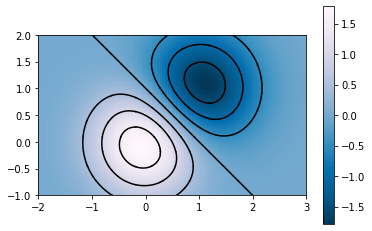

In [8]:
f=lambda x,y:2*(np.exp(-x**2-y**2)-np.exp(-(x-1)**2-(y-1)**2))


X,Y=np.linspace(-2,3,100),np.linspace(-1,2,100)

X,Y=np.meshgrid(X,Y)

Z=f(X,Y)

plt.pcolormesh(X, Y, Z,cmap='PuBu_r')
plt.colorbar()


case_x=12
case_y=12
delta=0.005

liste_c=[-1.5,-1,-0.5,0.0,0.5,1.0,1.5]

for c in liste_c:
    grille_x=list(np.linspace(-2,3,case_x))
    grille_y=list(np.linspace(-1,2,case_y))

    X_l,Y_l=contour(f,c,grille_x,grille_y,delta)

    for x, y in zip(X_l, Y_l):
        plt.plot(x, y,color="black")

ax = plt.gca()
ax.set_aspect('equal')

plt.show()